# <img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split,KFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LassoCV, ElasticNetCV, \
RidgeCV, LinearRegression
from sklearn.metrics import mean_squared_error

import statsmodels.formula.api as sm
import statsmodels.api as smf

In [3]:
pd.set_option('display.max_columns', 100)
fixeddf = pd.read_pickle("./fixeddf.pkl")
locationdf = pd.read_pickle("./locationdf.pkl")
universaldf =pd.read_pickle("./universaldf.pkl")
variabledf = pd.read_pickle("./variabledf.pkl")

In [4]:
# join all dfs together
dfs = [fixeddf, locationdf, universaldf, variabledf]
dfs = pd.concat(dfs, axis=1)

In [5]:
# split data into train and test
X = dfs.drop('SalePrice', axis=1)
y = dfs.SalePrice
Xtrain = X[X.YrSold != 2010]
y_train = dfs[dfs.YrSold !=  2010].SalePrice
Xtest = X[X.YrSold == 2010]
y_test = dfs[dfs.YrSold ==  2010].SalePrice
# drop saleprice from universaldf
universaldf.drop('SalePrice', axis=1, inplace=True)

In [6]:
# write function to slice and dice X variable
ss = StandardScaler()
def slicex(colcats):
    Xtrn = Xtrain[colcats.columns] 
    Xtst = Xtest[colcats.columns]            
    # standardize X VALUES using list of x variables
    Xtrnstd = pd.DataFrame(ss.fit_transform(Xtrn), columns=colcats.columns)
    Xtststd = pd.DataFrame(ss.transform(Xtst), columns=colcats.columns)
    return Xtrnstd, Xtststd


In [7]:
# run regression against location variables only
X_train = slicex(locationdf)[0]
X_test = slicex(locationdf)[1]

C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\schen24\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, **

In [8]:
# run simple linear regression
lm = LinearRegression()
model = lm.fit(X_train, y_train)
yhat_skl = lm.predict(X_test)
print('R2 baseline train:',model.score(X_train, y_train))
print('R2 baseline test:',model.score(X_test, y_test))
print('Mean squared error:', mean_squared_error(y_test, yhat_skl))

R2 baseline train: 0.5567256783158983
R2 baseline test: 0.544764453330922
Mean squared error: 2894114055.6824636


Text(0.5,1,'Actual vs. Predicted Home Values')

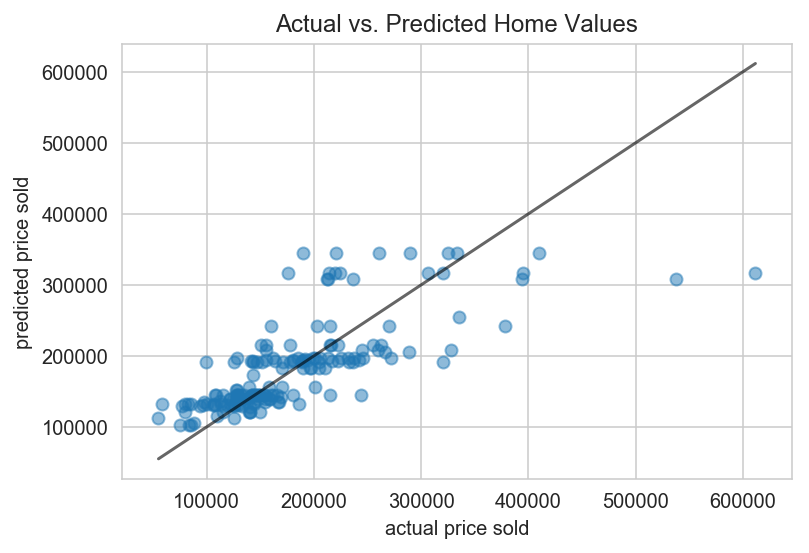

In [9]:
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], c = 'k', alpha = .6)
plt.scatter(y_test, yhat_skl, alpha = .5)
plt.xlabel('actual price sold')
plt.ylabel('predicted price sold')
plt.title('Actual vs. Predicted Home Values')

# 54.4% of house prices are attributed to location alone!  

In [10]:
# now try all fixed factors
allfixed = pd.concat([fixeddf, locationdf], axis=1)

In [11]:
X_train = slicex(allfixed)[0]
X_test = slicex(allfixed)[1]

C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\schen24\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data wit

In [12]:
lm = LinearRegression()
#cross-validate scores
def crossval(X_train, y_train,X_test, y_test, splits=10):
    kf_shuffle = KFold(n_splits=splits,shuffle=True)
    scores = cross_val_score(lm, X_train, y_train, cv=kf_shuffle) 
    yhat_skl = cross_val_predict(lm, X_test, y_test, cv=kf_shuffle)
    return np.mean(scores), np.std(scores), mean_squared_error(y_test, yhat_skl)

In [13]:
SLRCVallfixed = crossval(X_train, y_train,X_test, y_test, splits=10)
SLRCVallfixed
# not bad!! let's go ahead and run linear regression

(0.8483203571148585, 0.027553740598383683, 3.106001386181794e+32)

In [14]:
# run simple linear regression
model = lm.fit(X_train, y_train)
print('R2 baseline train score:',model.score(X_train, y_train))
print('R2 baseline test score:',model.score(X_test, y_test))
yhat_skl = lm.predict(X_test)
yhat = lm.predict(X_train)
# get y-residuals for train and test  for Q2.
yrestrain = -yhat+ y_train
yrestest = -yhat_skl + y_test
print('Mean squared error:', mean_squared_error(y_test, yhat_skl))
# pretty good!! 

R2 baseline train score: 0.8720508024123977
R2 baseline test score: 0.8564585796009495
Mean squared error: 912550097.1731025


In [15]:
# 85.6% of house prices are attributed to fixed hse features, which is roughly 30% more than 
# just location alone. 

# save scores
SLRallfixed = [model.score(X_test, y_test), np.nan, mean_squared_error(y_test, yhat_skl)]

Text(0.5,1,'Actual vs. Predicted Home Values')

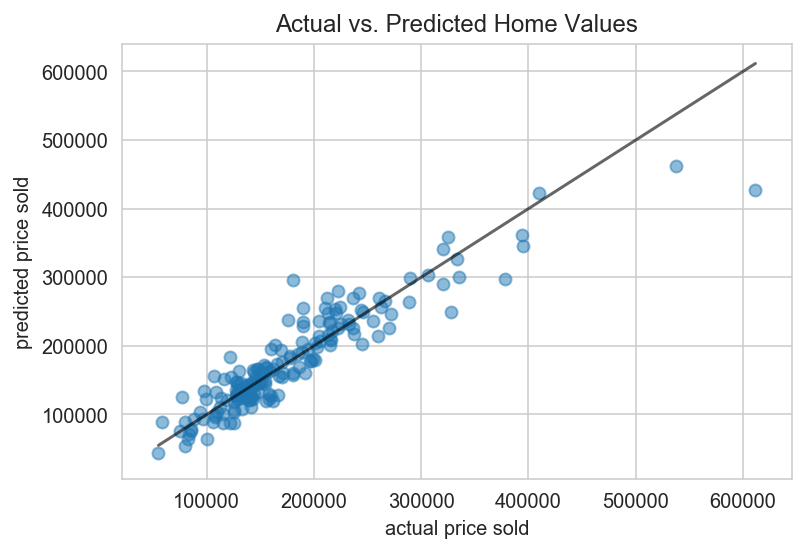

In [16]:
# plot actual vs predicted house values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], c = 'k', alpha = .6)
plt.scatter(y_test, yhat_skl, alpha = .5)
plt.xlabel('actual price sold')
plt.ylabel('predicted price sold')
plt.title('Actual vs. Predicted Home Values')

# 85.6% of house prices are attributed to fixed hse features, which is roughly 30% more than 
# just location alone. 

In [17]:
# note though that residuals are evenly spread on either side of regression line until about $350k (on x-axis), implying 
# that the model tends to consistently underpredict house prices. 

In [18]:
# print top coeffs
FixedCoefs = pd.DataFrame(lm.coef_, index= X_train.columns, columns=['Coef'])
FixedCoefs['AbsCoef'] = abs(FixedCoefs.Coef)
FixedCoefs.sort_values(by='AbsCoef', ascending=False, inplace=True)
FixedCoefs.head(10)

,Coef,AbsCoef
GrLivArea,36289.570856,36289.570856
GarageType_Attchd,15599.843629,15599.843629
GarageType_Detchd,13926.819176,13926.819176
GarageType_None,12604.576290,12604.576290
TotalBsmtSF,11208.745306,11208.745306
Neighborhood_NridgHt,10781.407609,10781.407609
GarageType_BuiltIn,9818.633109,9818.633109
BsmtExposure,8734.267885,8734.267885
Neighborhood_NoRidge,7941.068686,7941.068686
Neighborhood_StoneBr,7357.650142,7357.650142


#Regularization - to account for multicollinearity

In [19]:
# Lasso 
kf_shuffle = KFold(n_splits=10,shuffle=True)

LassCV = LassoCV(n_alphas=500, random_state= 182, cv=kf_shuffle)
LassCV.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True,
    cv=KFold(n_splits=10, random_state=None, shuffle=True), eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=500, n_jobs=None,
    normalize=False, positive=False, precompute='auto', random_state=182,
    selection='cyclic', tol=0.0001, verbose=False)

In [20]:
### View alpha and score
LassCV.alpha_, LassCV.score(X_train, y_train)

(291.0076254778931, 0.87031854695609)

In [21]:
### Setup Lasso regression using alpha calculated
Lass = Lasso(alpha=LassCV.alpha_)

In [22]:
### Run cross validated lasso
LassScore = cross_val_score(Lass,X_test, y_test, cv=kf_shuffle)
predictions = cross_val_predict(Lass,X_test, y_test, cv=kf_shuffle)
print('Mean Lasso score:', np.mean(LassScore))
print('Std Lasso score:', np.std(LassScore))
print('Mean squared error:', mean_squared_error(y_test, predictions))

Mean Lasso score: 0.6661231638826066
Std Lasso score: 0.21922395235498493
Mean squared error: 1672006896.6122758


In [23]:
Lassoallfixed = [np.mean(LassScore),np.std(LassScore),mean_squared_error(y_test, predictions) ]

In [24]:
### Run Lasso to get the most predictive coefficients.
Lass.fit(X_train, y_train)

Lasso(alpha=291.0076254778931, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [25]:
### Map lasso coefficients to its column names
dfl = pd.DataFrame(Lass.coef_, index= allfixed.columns, columns=['Coef'])
dfl['AbsCoef'] = abs(dfl.Coef)
LassoCoefs = dfl[~(abs(dfl['Coef']) == 0)].sort_values(by='AbsCoef', ascending=False)
LassoCoefs.head(10)

,Coef,AbsCoef
GrLivArea,36514.003207,36514.003207
TotalBsmtSF,11399.155609,11399.155609
Neighborhood_NridgHt,8928.965548,8928.965548
BsmtExposure,8248.593087,8248.593087
YearRemodAdd,7288.635804,7288.635804
Neighborhood_NoRidge,6344.510404,6344.510404
Neighborhood_StoneBr,6229.637207,6229.637207
MasVnrArea,6183.456479,6183.456479
KitchenAbvGr,-6078.846551,6078.846551
BedroomAbvGr,-5702.585832,5702.585832


In [26]:
#the top features are quite similar to the linear regression run, but R2 score for Lasso is not as good. 

In [27]:
# regularization
#ridge
from sklearn.linear_model import Ridge

ridge_alphas = 10**np.linspace(10,-2,50)*0.5   # np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train, y_train)

ridge = Ridge(alpha=optimal_ridge.alpha_)
predictions = cross_val_predict(ridge, X_test, y_test, cv=10)

ridge_scores = cross_val_score(ridge, X_test, y_test, cv=10)

print('Mean CV R2:', np.mean(ridge_scores))
print('Std CV R2:', np.std(ridge_scores))
print('Mean squared error:', mean_squared_error(y_test, predictions))


Mean CV R2: 0.7697954836524237
Std CV R2: 0.08153643475818208
Mean squared error: 1466213933.4293902


In [28]:
Ridgeallfixed = [np.mean(ridge_scores),np.std(ridge_scores),mean_squared_error(y_test, predictions) ]

In [29]:
#elasticnet

enet_alphas =[ 0.0125, 0.025, 0.05, .125, .25, .5, 1., 2., 4.]  # np.logspace(-2, 7, 50)

optimal_enet = ElasticNetCV(alphas = enet_alphas, cv=10)
optimal_enet.fit(X_train, y_train)

enet = ElasticNet(alpha=optimal_enet.alpha_)
predictions = cross_val_predict(enet, X_test, y_test, cv=10)

enet_scores = cross_val_score(enet, X_test, y_test, cv=10)

print('Mean CV R2:', np.mean(enet_scores))
print('Std CV R2:', np.std(enet_scores))
print('Mean squared error:', mean_squared_error(y_test, predictions))


Mean CV R2: 0.7056769273833825
Std CV R2: 0.11930063876710362
Mean squared error: 1636156309.1838589


In [30]:
Enetallfixed = [np.mean(enet_scores),np.std(enet_scores),mean_squared_error(y_test, predictions) ]

In [31]:
results = {'SLRallfixed': SLRallfixed, 'Lassoallfixed':Lassoallfixed,'Ridgeallfixed':Ridgeallfixed,'Enetallfixed':Enetallfixed}
results

{'SLRallfixed': [0.8564585796009495, nan, 912550097.1731025],
 'Lassoallfixed': [0.6661231638826066,
  0.21922395235498493,
  1672006896.6122758],
 'Ridgeallfixed': [0.7697954836524237,
  0.08153643475818208,
  1466213933.4293902],
 'Enetallfixed': [0.7056769273833825, 0.11930063876710362, 1636156309.1838589]}

In [32]:
# now let's try using the top 15 features from 'FixedCoefs' to see if scores improve
# the R2 for the train set was 85.6% last time.
FixedCoefs10 = dfs[FixedCoefs.index[0:10]]

In [33]:
# slice x values again
X_train = slicex(FixedCoefs10)[0]
X_test = slicex(FixedCoefs10)[1]
X_train.head()

C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\schen24\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\schen24\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64 we

,GrLivArea,GarageType_Attchd,GarageType_Detchd,GarageType_None,TotalBsmtSF,Neighborhood_NridgHt,GarageType_BuiltIn,BsmtExposure,Neighborhood_NoRidge,Neighborhood_StoneBr
0,0.381329,0.823983,-0.607535,-0.237258,-0.476784,-0.239095,-0.253417,-0.631694,-0.165455,-0.126189
1,-0.500427,0.823983,-0.607535,-0.237258,0.500110,-0.239095,-0.253417,2.240189,-0.165455,-0.126189
2,0.530912,0.823983,-0.607535,-0.237258,-0.322791,-0.239095,-0.253417,0.325600,-0.165455,-0.126189
3,0.395106,-1.213618,1.645996,-0.237258,-0.717398,-0.239095,-0.253417,-0.631694,-0.165455,-0.126189
4,1.341812,0.823983,-0.607535,-0.237258,0.218591,-0.239095,-0.253417,1.282895,6.043957,-0.126189


In [34]:
# run Ridge, SLR and Lasso with top 10 fixed features
from sklearn.linear_model import Ridge

ridge_alphas = 10**np.linspace(10,-2,50)*0.5   # np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train, y_train)

ridge = Ridge(alpha=optimal_ridge.alpha_)
predictions = cross_val_predict(ridge, X_test, y_test, cv=10)

ridge_scores = cross_val_score(ridge, X_test, y_test, cv=10)

print('Mean CV R2:', np.mean(ridge_scores))
print('Std CV R2:', np.std(ridge_scores))
print('Mean squared error:', mean_squared_error(y_test, predictions))
Ridgeallfixed10 = [np.mean(ridge_scores),np.std(ridge_scores),mean_squared_error(y_test, predictions) ]

Mean CV R2: 0.6994569638695068
Std CV R2: 0.13222189767030068
Mean squared error: 1634461960.9148698


In [35]:
# run simple linear regression on top 10 factors

lm = LinearRegression()

model = lm.fit(X_train, y_train)

print('R2 baseline train score:',model.score(X_train, y_train))

print('R2 baseline test score:',model.score(X_test, y_test))

yhat_skl = lm.predict(X_test)

print('Mean squared error:', mean_squared_error(y_test, yhat_skl))

R2 baseline train score: 0.7871043953953534
R2 baseline test score: 0.795775167600816
Mean squared error: 1298338766.1410432


In [36]:
SLRallfixed10 = [model.score(X_test, y_test), np.nan, mean_squared_error(y_test, yhat_skl)]

In [37]:
# Lasso w top 10 factors

kf_shuffle = KFold(n_splits=10,shuffle=True)
LassCV = LassoCV(n_alphas=500, cv=kf_shuffle)
LassCV.fit(X_train, y_train)

### View alpha and score
LassCV.alpha_, LassCV.score(X_train, y_train)

### Setup Lasso regression using alpha calculated
Lass = Lasso(alpha=LassCV.alpha_)

### Run cross validated lasso
LassScore = cross_val_score(Lass,X_test, y_test, cv=kf_shuffle)
predictions = cross_val_predict(Lass,X_test, y_test, cv=kf_shuffle)
print('Mean Lasso score:', np.mean(LassScore))
print('Std Lasso score:', np.std(LassScore))
print('Mean squared error:', mean_squared_error(y_test, predictions))

Mean Lasso score: 0.6364841484594863
Std Lasso score: 0.3948465740207756
Mean squared error: 1531898598.7671576


In [38]:
Lassoallfixed10 = [np.mean(LassScore),np.std(LassScore),mean_squared_error(y_test, predictions) ]

In [39]:
results.update({'SLRallfixed10': SLRallfixed10,'Lassoallfixed10': Lassoallfixed10, 'Ridgeallfixed10':Ridgeallfixed10})

In [40]:
# print summary of results of all linear regressions
pd.DataFrame.from_dict(results, orient='index', columns=['Mean', 'Std Dev', 'MSE']).sort_values(by='Mean', ascending=False)


,Mean,Std Dev,MSE
SLRallfixed,0.856459,NaN,9.125501e+08
SLRallfixed10,0.795775,NaN,1.298339e+09
Ridgeallfixed,0.769795,0.081536,1.466214e+09
Enetallfixed,0.705677,0.119301,1.636156e+09
Ridgeallfixed10,0.699457,0.132222,1.634462e+09
Lassoallfixed,0.666123,0.219224,1.672007e+09
Lassoallfixed10,0.636484,0.394847,1.531899e+09


CONCLUSION: 
1) simple linear regression seems to perform best among all the regression models, while using all fixed factors gave better results than just using the top 10. we will therefore use the residuals from 'SLRallfixed' to model against renovatable factors in Q2.  
2) the top factors affecting property prices are: Gross Living Area, Garage Type, Basement Area / exposure and the neighbourhood the house is located in. The results are consistent with EDA done earlier on simple correlation between neighbourhoods and sale price, house size and sale price. 
3) the model tends to underpredict actual house prices after $350k, which may imply that other unaccounted factors are strongly affecting house prices above this price point. 

In [41]:
# store y residuals from SLR regression earlier
%store yrestrain
%store yrestest
%store FixedCoefs
#del data

Stored 'yrestrain' (Series)
Stored 'yrestest' (Series)
Stored 'FixedCoefs' (DataFrame)
